Importation de packages et de librairies

In [10]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm


Importation de la base de donnees

In [39]:
df=pd.read_excel("DATAN.xlsx")
df

,An,Recettes,PIB,IPC,CHANGE
0,1999,4.824380e+09,2.7,9.920635,16.941100
1,2000,4.441760e+09,0.9,17.083779,24.124092
2,2001,4.550970e+09,-1.1,9.351166,26.880425
3,2002,5.686400e+09,-0.5,24.368735,39.616983
4,2003,3.449260e+09,0.5,29.776429,39.896517
5,2004,4.172650e+09,-3.8,17.652600,38.712942
6,2005,4.200260e+09,1.8,14.455228,41.672350
7,2006,6.378580e+09,2.2,9.358333,37.515508
8,2007,8.013916e+09,3.3,13.283333,38.108637
9,2008,3.309464e+09,0.8,5.839022,40.609485


exploration de donnees

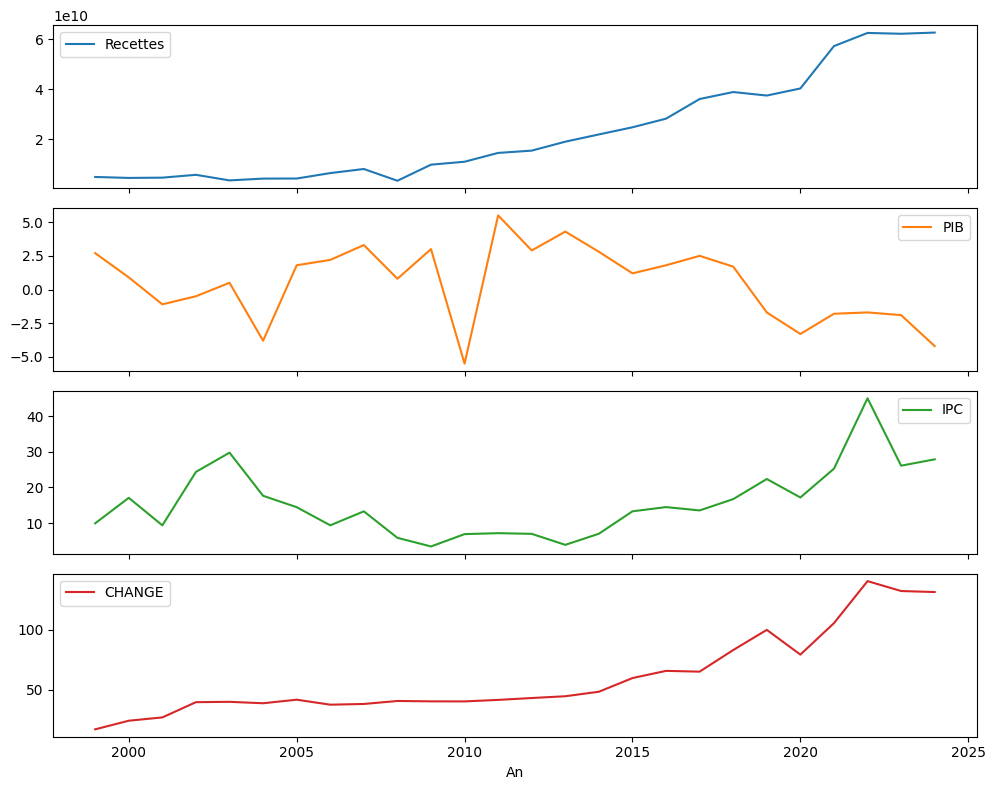

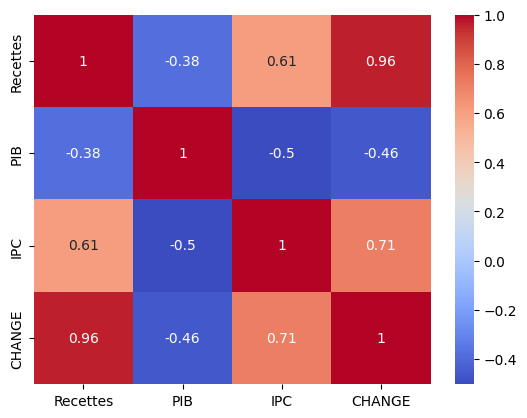

In [40]:
# Courbes d’évolution
df.set_index('An')[['Recettes', 'PIB', 'IPC', 'CHANGE']].plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Corrélations
sns.heatmap(df[['Recettes', 'PIB', 'IPC', 'CHANGE']].corr(), annot=True, cmap='coolwarm')
plt.show()


Test de stationnarité pour les series

In [15]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("-" * 40)

for col in ['Recettes', 'PIB', 'IPC', 'CHANGE']:
    adf_test(df[col], col)


ADF Test for Recettes:
  ADF Statistic: -0.0039
  p-value: 0.9582
  Non-stationary
----------------------------------------
ADF Test for PIB:
  ADF Statistic: -1.8495
  p-value: 0.3562
  Non-stationary
----------------------------------------
ADF Test for IPC:
  ADF Statistic: -0.0369
  p-value: 0.9554
  Non-stationary
----------------------------------------
ADF Test for CHANGE:
  ADF Statistic: 2.0967
  p-value: 0.9988
  Non-stationary
----------------------------------------


Test de cointegration, tester si une combinaison lineaire de serie non stationnaire deviens stationnaire

In [16]:
# Étape 1 : Régression sur les niveaux
X = df[['PIB', 'IPC', 'CHANGE']]
X = sm.add_constant(X)
y = df['Recettes']
model = sm.OLS(y, X).fit()

# Étape 2 : Tester la stationnarité des résidus
residuals = model.resid
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("  Stationary" if result[1] < 0.05 else "  Non-stationary")

ADF Statistic: -0.9160025475478335
p-value: 0.7826568806232612
  Non-stationary


differencier les 4 series a l'ordre 1

In [33]:
# Différenciation simple (1re différence)
df['dRecettes'] = np.log(df['Recettes']) - np.log(df['Recettes'].shift(1))
df['dPIB'] = df['PIB'] - df['PIB'].shift(1)
df['dIPC'] = df['IPC'] - df['IPC'].shift(1)
df['dCHANGE'] = df['CHANGE'] - df['CHANGE'].shift(1)


# Supprimer la première ligne (valeurs manquantes)
df_model = df.dropna()

df_model

,An,Recettes,PIB,IPC,CHANGE,dRecettes,dPIB,dIPC,dCHANGE
2,2001,4.550970e+09,-1.1,9.351166,2.756333,0.024290,-2.0,-7.732613,-4.426658
3,2002,5.686400e+09,-0.5,24.368735,12.736558,0.222737,0.6,15.017569,9.980225
4,2003,3.449260e+09,0.5,29.776429,0.279533,-0.499918,1.0,5.407694,-12.457025
5,2004,4.172650e+09,-3.8,17.652600,-1.183575,0.190392,-4.3,-12.123829,-1.463108
6,2005,4.200260e+09,1.8,14.455228,2.959408,0.006595,5.6,-3.197372,4.142983
7,2006,6.378580e+09,2.2,9.358333,-4.156842,0.417799,0.4,-5.096895,-7.116250
8,2007,8.013916e+09,3.3,13.283333,0.593128,0.228234,1.1,3.925000,4.749970
9,2008,3.309464e+09,0.8,5.839022,2.500849,-0.884393,-2.5,-7.444312,1.907720
10,2009,9.747660e+09,3.0,3.414330,-0.315289,1.080241,2.2,-2.424691,-2.816138
11,2010,1.092612e+10,-5.5,6.883333,-0.048887,0.114129,-8.5,3.469003,0.266402


test de stationnarite sur les serie diffencier

In [34]:
for col in ['dRecettes', 'dPIB', 'dIPC', 'dCHANGE']:
    adf_test(df_model[col], col)

ADF Test for dRecettes:
  ADF Statistic: -7.5707
  p-value: 0.0000
  Stationary
----------------------------------------
ADF Test for dPIB:
  ADF Statistic: -9.0682
  p-value: 0.0000
  Stationary
----------------------------------------
ADF Test for dIPC:
  ADF Statistic: -1.4994
  p-value: 0.5338
  Non-stationary
----------------------------------------
ADF Test for dCHANGE:
  ADF Statistic: -0.9087
  p-value: 0.7851
  Non-stationary
----------------------------------------


creer les variables X et Y

In [35]:
X = df_model[['dPIB', 'dIPC', 'dCHANGE']]
X = sm.add_constant(X)  # Ajout de la constante
y = df_model['dRecettes']


In [36]:
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              dRecettes   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.063
Method:                 Least Squares   F-statistic:                    0.5431
Date:                Wed, 25 Jun 2025   Prob (F-statistic):              0.658
Time:                        09:15:27   Log-Likelihood:                -6.5185
No. Observations:                  24   AIC:                             21.04
Df Residuals:                      20   BIC:                             25.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1159      0.071      1.624      0.1

In [37]:
residuals = model1.resid
result = adfuller(residuals)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("  Stationary" if result[1] < 0.05 else "  Non-stationary")

ADF Statistic: -0.9791915947080191
p-value: 0.7607778353690462
  Non-stationary


Modele avec le PIb uniquement

In [38]:
X = df_model[['dPIB']]
X = sm.add_constant(X)  # Ajout de la constante
y = df_model['dRecettes']
model2 = sm.OLS(y, X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              dRecettes   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.448
Date:                Wed, 25 Jun 2025   Prob (F-statistic):              0.242
Time:                        11:00:35   Log-Likelihood:                -6.6933
No. Observations:                  24   AIC:                             17.39
Df Residuals:                      22   BIC:                             19.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1152      0.068      1.687      0.1